In [1]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn wordcloud -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

# Set plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load All Agreement Levels

In [3]:
# Load all agreement levels
def load_dataset(filename):
    """Load dataset from file"""
    sentences = []
    sentiments = []

    with open(filename, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if "@" in line:
                parts = line.rsplit("@", 1)
                if len(parts) == 2:
                    sentences.append(parts[0].strip())
                    sentiments.append(parts[1].strip())

    return pd.DataFrame({"sentence": sentences, "sentiment": sentiments})


# Load all agreement levels
df_50 = load_dataset("FinancialPhraseBank-v1.0/Sentences_50Agree.txt")
df_66 = load_dataset("FinancialPhraseBank-v1.0/Sentences_66Agree.txt")
df_75 = load_dataset("FinancialPhraseBank-v1.0/Sentences_75Agree.txt")
df_100 = load_dataset("FinancialPhraseBank-v1.0/Sentences_AllAgree.txt")

print("Dataset Sizes by Agreement Level:")
print(f"  50% Agreement: {len(df_50):,} sentences")
print(f"  66% Agreement: {len(df_66):,} sentences")
print(f"  75% Agreement: {len(df_75):,} sentences")
print(f" 100% Agreement: {len(df_100):,} sentences")

Dataset Sizes by Agreement Level:
  50% Agreement: 4,846 sentences
  66% Agreement: 4,217 sentences
  75% Agreement: 3,453 sentences
 100% Agreement: 2,264 sentences


## 2. Sentiment Distribution Analysis

In [4]:
# Create comparison dataframe
agreement_levels = ["50%", "66%", "75%", "100%"]
datasets = [df_50, df_66, df_75, df_100]

distribution_data = []
for level, df in zip(agreement_levels, datasets):
    counts = df["sentiment"].value_counts()
    total = len(df)
    distribution_data.append(
        {
            "Agreement": level,
            "Total": total,
            "Positive": counts.get("positive", 0),
            "Negative": counts.get("negative", 0),
            "Neutral": counts.get("neutral", 0),
            "Positive %": (counts.get("positive", 0) / total * 100),
            "Negative %": (counts.get("negative", 0) / total * 100),
            "Neutral %": (counts.get("neutral", 0) / total * 100),
        }
    )

dist_df = pd.DataFrame(distribution_data)
print("\n" + "=" * 80)
print("SENTIMENT DISTRIBUTION BY AGREEMENT LEVEL")
print("=" * 80)
display(dist_df)


SENTIMENT DISTRIBUTION BY AGREEMENT LEVEL


,Agreement,Total,Positive,Negative,Neutral,Positive %,Negative %,Neutral %
0,50%,4846,1363,604,2879,28.126290,12.463888,59.409823
1,66%,4217,1168,514,2535,27.697415,12.188760,60.113825
2,75%,3453,887,420,2146,25.687808,12.163336,62.148856
3,100%,2264,570,303,1391,25.176678,13.383392,61.439929


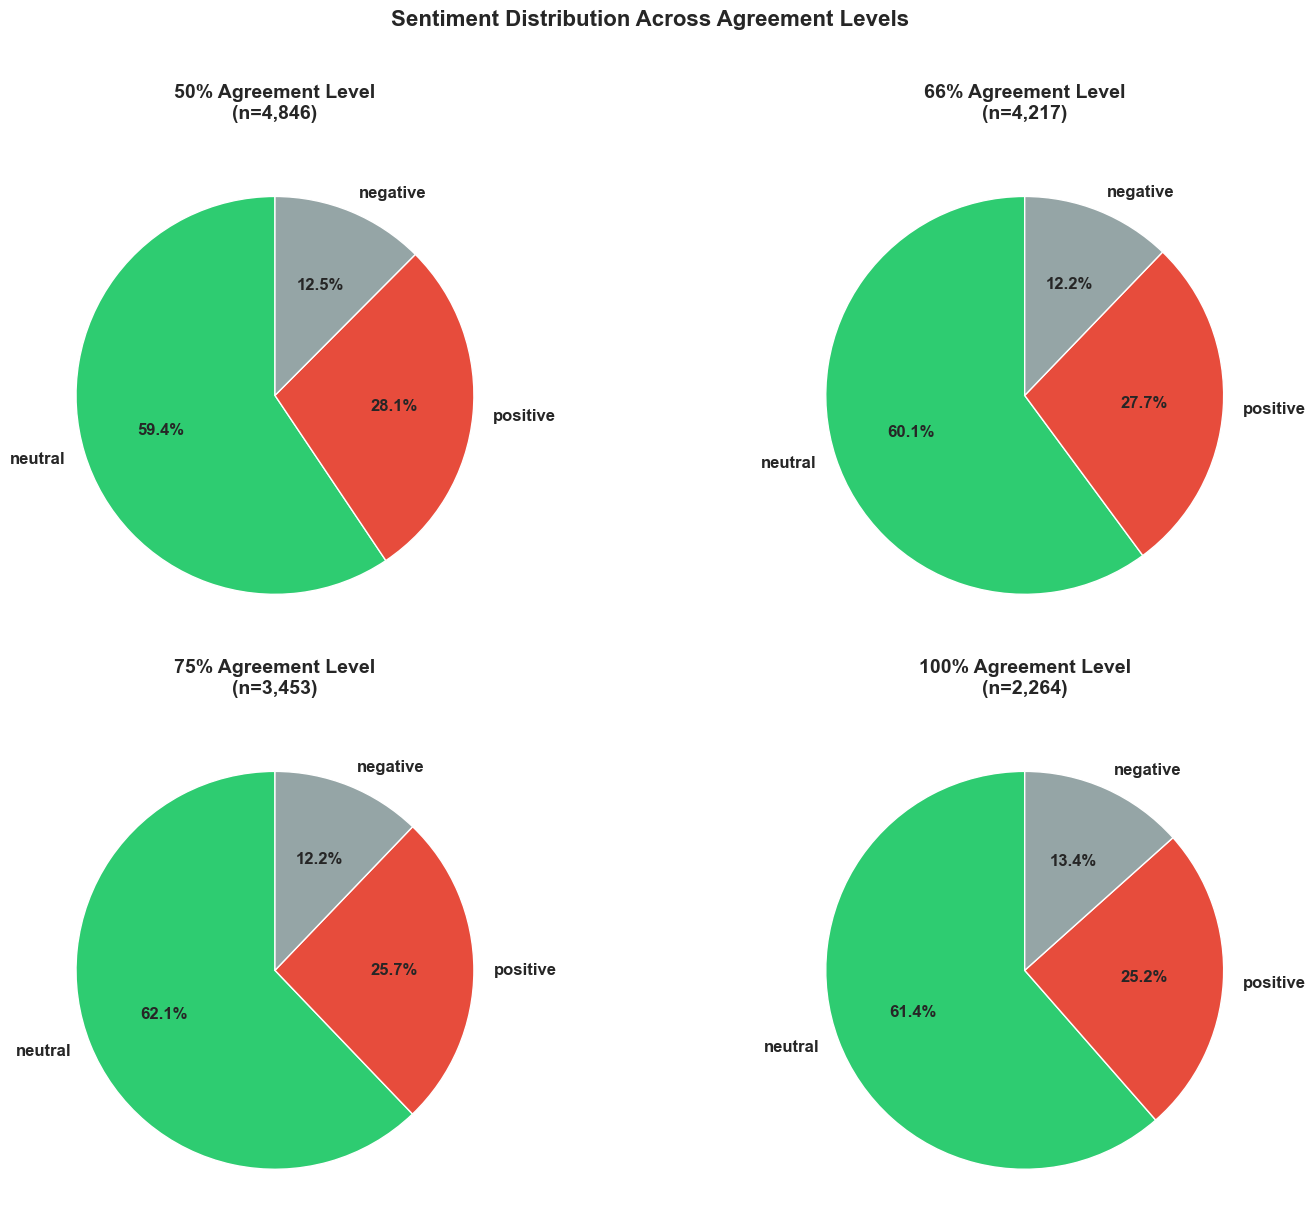

In [5]:
# Visualize distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = ["#2ecc71", "#e74c3c", "#95a5a6"]  # positive, negative, neutral

for idx, (level, df, ax) in enumerate(zip(agreement_levels, datasets, axes.flat)):
    counts = df["sentiment"].value_counts()

    # Pie chart
    ax.pie(
        counts.values,
        labels=counts.index,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        textprops={"fontsize": 12, "weight": "bold"},
    )
    ax.set_title(
        f"{level} Agreement Level\n(n={len(df):,})", fontsize=14, weight="bold", pad=20
    )

plt.suptitle(
    "Sentiment Distribution Across Agreement Levels", fontsize=16, weight="bold", y=1.02
)
plt.tight_layout()
plt.savefig("sentiment_distribution_by_agreement.png", dpi=300, bbox_inches="tight")
plt.show()

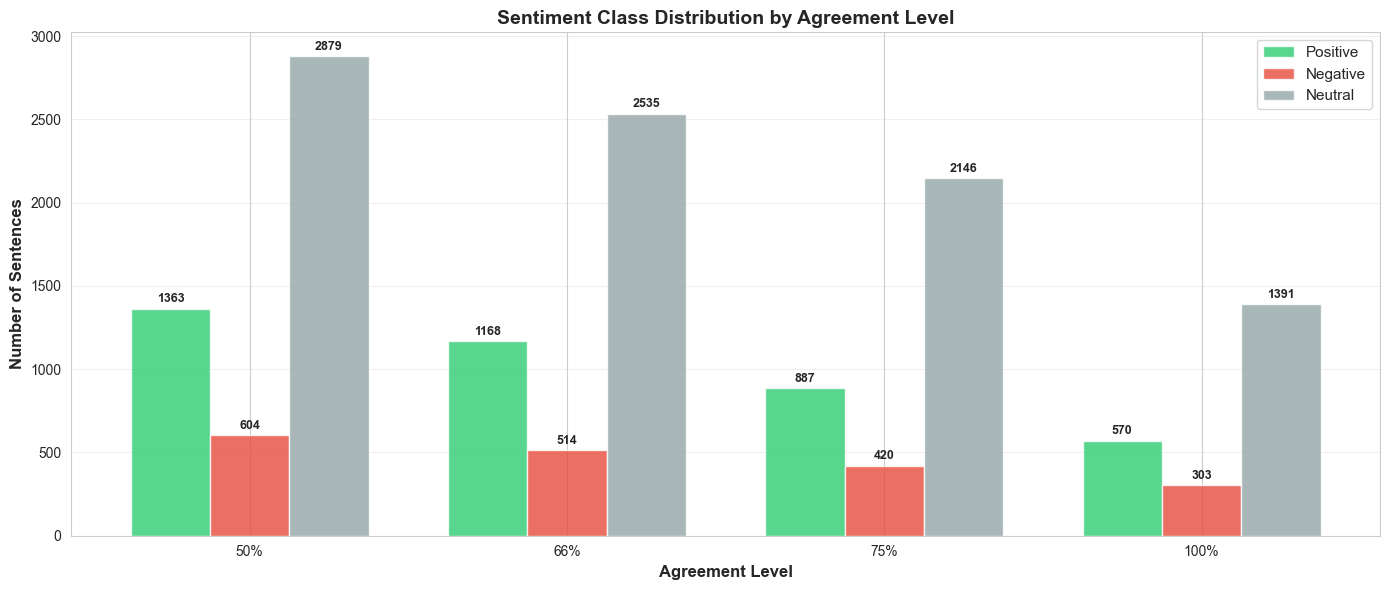

In [6]:
# Class imbalance analysis
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(agreement_levels))
width = 0.25

positive_counts = [d["Positive"] for d in distribution_data]
negative_counts = [d["Negative"] for d in distribution_data]
neutral_counts = [d["Neutral"] for d in distribution_data]

ax.bar(x - width, positive_counts, width, label="Positive", color="#2ecc71", alpha=0.8)
ax.bar(x, negative_counts, width, label="Negative", color="#e74c3c", alpha=0.8)
ax.bar(x + width, neutral_counts, width, label="Neutral", color="#95a5a6", alpha=0.8)

ax.set_xlabel("Agreement Level", fontsize=12, weight="bold")
ax.set_ylabel("Number of Sentences", fontsize=12, weight="bold")
ax.set_title(
    "Sentiment Class Distribution by Agreement Level", fontsize=14, weight="bold"
)
ax.set_xticks(x)
ax.set_xticklabels(agreement_levels)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for i, (pos, neg, neu) in enumerate(
    zip(positive_counts, negative_counts, neutral_counts)
):
    ax.text(
        i - width,
        pos + 20,
        str(pos),
        ha="center",
        va="bottom",
        fontsize=9,
        weight="bold",
    )
    ax.text(i, neg + 20, str(neg), ha="center", va="bottom", fontsize=9, weight="bold")
    ax.text(
        i + width,
        neu + 20,
        str(neu),
        ha="center",
        va="bottom",
        fontsize=9,
        weight="bold",
    )

plt.tight_layout()
plt.savefig("class_distribution_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

## 3. Class Imbalance Metrics

In [7]:
# Calculate imbalance ratio and metrics
imbalance_metrics = []

for level, df in zip(agreement_levels, datasets):
    counts = df["sentiment"].value_counts()
    total = len(df)

    majority_class = counts.max()
    minority_class = counts.min()
    imbalance_ratio = majority_class / minority_class

    # Gini coefficient for inequality
    sorted_counts = np.sort(counts.values)
    n = len(sorted_counts)
    gini = (2 * np.sum((np.arange(1, n + 1) * sorted_counts))) / (
        n * np.sum(sorted_counts)
    ) - (n + 1) / n

    imbalance_metrics.append(
        {
            "Agreement": level,
            "Majority Class": counts.idxmax(),
            "Majority Count": majority_class,
            "Minority Class": counts.idxmin(),
            "Minority Count": minority_class,
            "Imbalance Ratio": f"{imbalance_ratio:.2f}:1",
            "Gini Coefficient": f"{gini:.3f}",
        }
    )

imbalance_df = pd.DataFrame(imbalance_metrics)
print("\n" + "=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)
print("Note: Gini coefficient ranges from 0 (perfect balance) to 1 (maximum imbalance)")
display(imbalance_df)


CLASS IMBALANCE ANALYSIS
Note: Gini coefficient ranges from 0 (perfect balance) to 1 (maximum imbalance)


,Agreement,Majority Class,Majority Count,Minority Class,Minority Count,Imbalance Ratio,Gini Coefficient
0,50%,neutral,2879,negative,604,4.77:1,0.313
1,66%,neutral,2535,negative,514,4.93:1,0.320
2,75%,neutral,2146,negative,420,5.11:1,0.333
3,100%,neutral,1391,negative,303,4.59:1,0.320


## 4. Sentence Length Analysis

In [8]:
# Analyze sentence lengths across agreement levels
for df, level in zip(datasets, agreement_levels):
    df["word_count"] = df["sentence"].str.split().str.len()
    df["char_count"] = df["sentence"].str.len()

# Combined statistics
length_stats = []
for level, df in zip(agreement_levels, datasets):
    for sentiment in ["positive", "negative", "neutral"]:
        subset = df[df["sentiment"] == sentiment]
        if len(subset) > 0:
            length_stats.append(
                {
                    "Agreement": level,
                    "Sentiment": sentiment,
                    "Count": len(subset),
                    "Avg Words": subset["word_count"].mean(),
                    "Median Words": subset["word_count"].median(),
                    "Min Words": subset["word_count"].min(),
                    "Max Words": subset["word_count"].max(),
                    "Std Words": subset["word_count"].std(),
                }
            )

length_df = pd.DataFrame(length_stats)
print("\n" + "=" * 80)
print("SENTENCE LENGTH STATISTICS BY SENTIMENT")
print("=" * 80)
display(length_df.round(2))


SENTENCE LENGTH STATISTICS BY SENTIMENT


,Agreement,Sentiment,Count,Avg Words,Median Words,Min Words,Max Words,Std Words
0,50%,positive,1363,24.69,23.0,5,57,10.06
1,50%,negative,604,23.92,22.0,5,56,9.89
2,50%,neutral,2879,22.18,21.0,2,81,9.82
3,66%,positive,1168,24.65,23.0,5,57,10.06
4,66%,negative,514,24.08,22.0,5,56,10.05
5,66%,neutral,2535,22.06,21.0,2,81,9.91
6,75%,positive,887,24.88,23.0,6,57,10.31
7,75%,negative,420,24.47,22.0,5,56,10.13
8,75%,neutral,2146,21.55,20.0,2,81,9.76
9,100%,positive,570,24.88,23.0,6,57,10.48


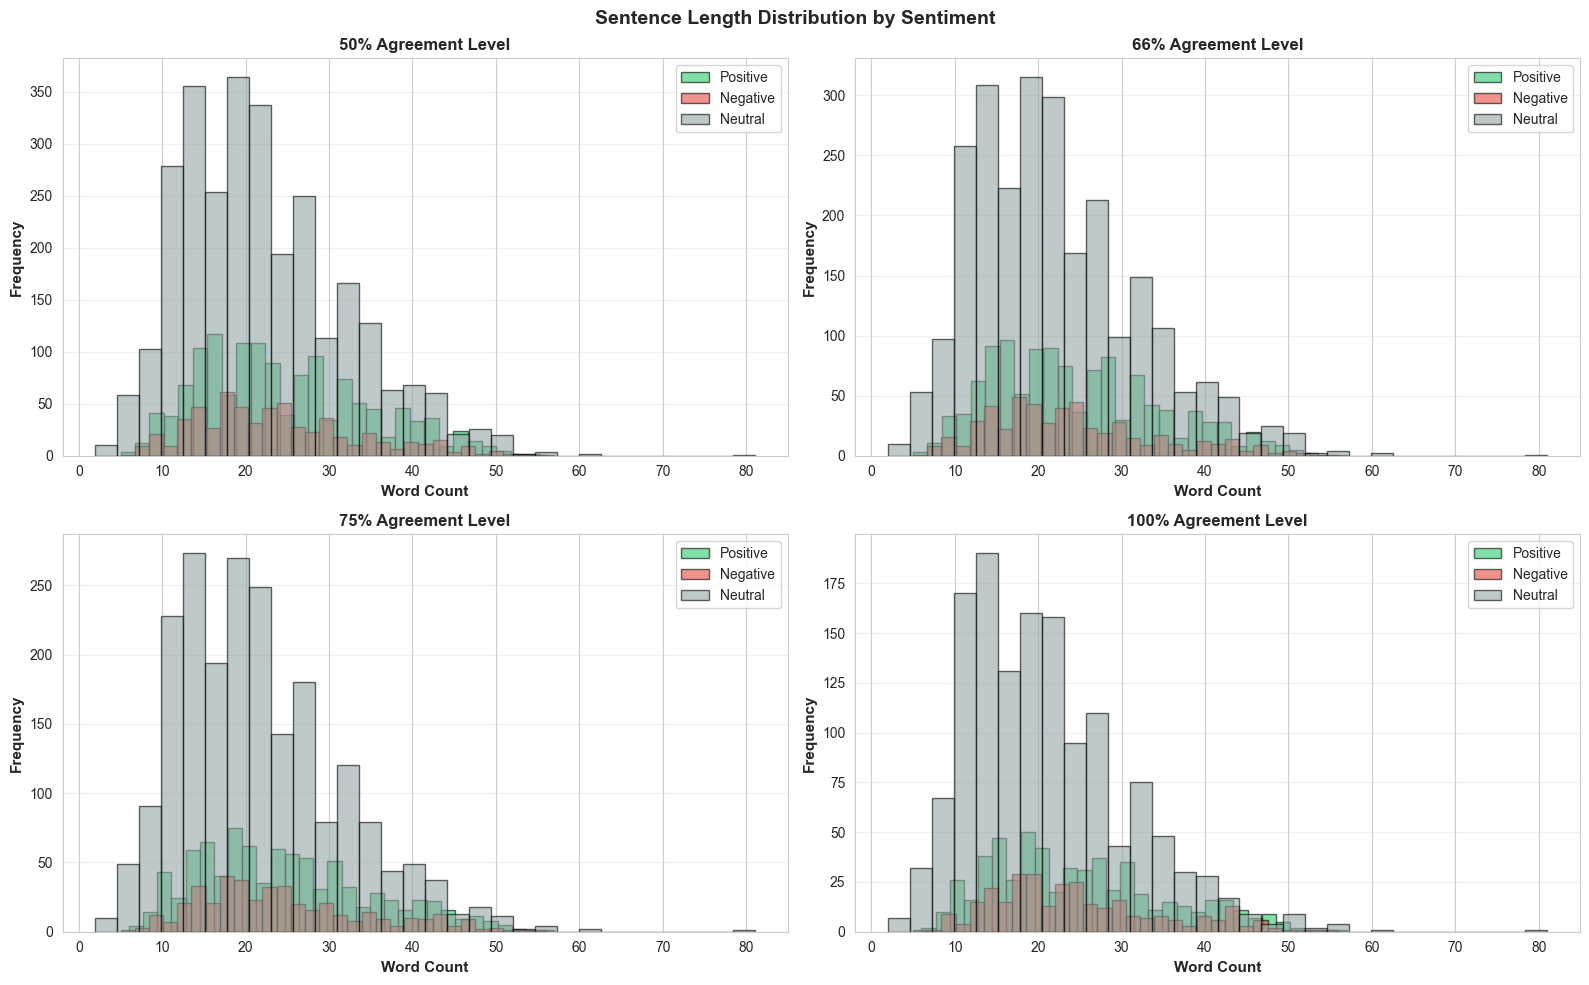

In [9]:
# Visualize sentence length distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, (level, df, ax) in enumerate(zip(agreement_levels, datasets, axes.flat)):
    for sentiment, color in zip(["positive", "negative", "neutral"], colors):
        subset = df[df["sentiment"] == sentiment]["word_count"]
        ax.hist(
            subset,
            bins=30,
            alpha=0.6,
            label=sentiment.capitalize(),
            color=color,
            edgecolor="black",
        )

    ax.set_xlabel("Word Count", fontsize=11, weight="bold")
    ax.set_ylabel("Frequency", fontsize=11, weight="bold")
    ax.set_title(f"{level} Agreement Level", fontsize=12, weight="bold")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

plt.suptitle("Sentence Length Distribution by Sentiment", fontsize=14, weight="bold")
plt.tight_layout()
plt.savefig("sentence_length_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

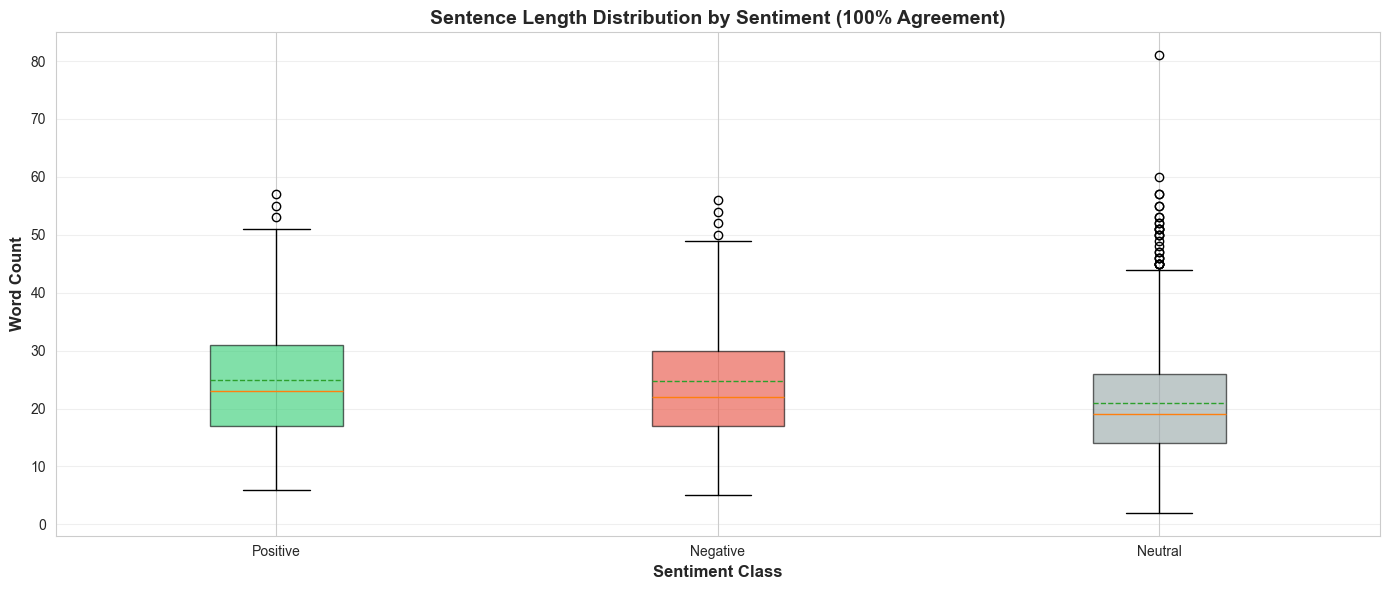

In [10]:
# Box plot comparison
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data for box plot (using 100% agreement for clarity)
data_to_plot = [
    df_100[df_100["sentiment"] == s]["word_count"]
    for s in ["positive", "negative", "neutral"]
]

bp = ax.boxplot(
    data_to_plot,
    labels=["Positive", "Negative", "Neutral"],
    patch_artist=True,
    showmeans=True,
    meanline=True,
)

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel("Word Count", fontsize=12, weight="bold")
ax.set_xlabel("Sentiment Class", fontsize=12, weight="bold")
ax.set_title(
    "Sentence Length Distribution by Sentiment (100% Agreement)",
    fontsize=14,
    weight="bold",
)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("sentence_length_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

## 5. Word Frequency Analysis

In [11]:
# Analyze most common words per sentiment (using 100% agreement)
from collections import Counter
import re


def get_word_frequencies(df, sentiment, top_n=20):
    """Extract most common words for a given sentiment"""
    subset = df[df["sentiment"] == sentiment]["sentence"]

    # Combine all sentences and tokenize
    text = " ".join(subset).lower()
    # Remove special characters and numbers
    words = re.findall(r"\b[a-z]+\b", text)

    # Remove common stop words
    stop_words = {
        "the",
        "a",
        "an",
        "and",
        "or",
        "but",
        "in",
        "on",
        "at",
        "to",
        "for",
        "of",
        "with",
        "by",
        "from",
        "is",
        "was",
        "are",
        "were",
        "been",
        "be",
        "have",
        "has",
        "had",
        "do",
        "does",
        "did",
        "will",
        "would",
        "could",
        "should",
        "may",
        "might",
        "can",
        "their",
        "there",
        "they",
        "them",
        "this",
        "that",
        "these",
        "those",
        "it",
        "its",
        "as",
        "said",
    }

    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]

    return Counter(filtered_words).most_common(top_n)


# Get top words for each sentiment
print("\n" + "=" * 80)
print("TOP 20 WORDS BY SENTIMENT (100% Agreement Dataset)")
print("=" * 80)

for sentiment, color_name in zip(
    ["positive", "negative", "neutral"], ["green", "red", "gray"]
):
    print(f"\n{sentiment.upper()} Sentiment:")
    top_words = get_word_frequencies(df_100, sentiment, 20)
    for word, count in top_words:
        print(f"  {word:20s} : {count:4d}")


TOP 20 WORDS BY SENTIMENT (100% Agreement Dataset)

POSITIVE Sentiment:
  eur                  :  375
  profit               :  172
  net                  :  166
  year                 :  155
  sales                :  129
  period               :  125
  million              :  118
  finnish              :  108
  operating            :  103
  mln                  :   99
  quarter              :   89
  company              :   86
  rose                 :   82
  increased            :   74
  loss                 :   60
  corresponding        :   59
  oyj                  :   59
  compared             :   58
  euro                 :   53
  group                :   50

NEGATIVE Sentiment:
  eur                  :  251
  profit               :  122
  net                  :   84
  sales                :   72
  year                 :   72
  quarter              :   71
  operating            :   68
  down                 :   65
  mln                  :   62
  period               :   58
  mill

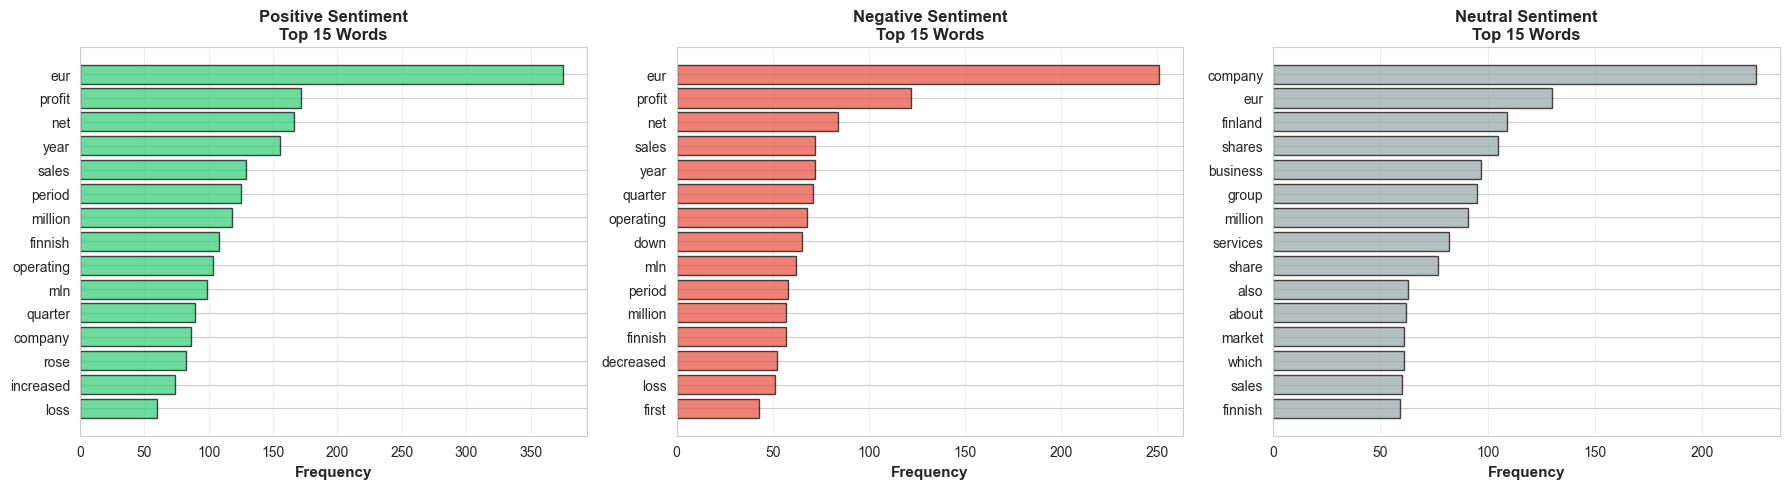

In [12]:
# Visualize top words
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (sentiment, color, ax) in enumerate(
    zip(["positive", "negative", "neutral"], colors, axes)
):
    top_words = get_word_frequencies(df_100, sentiment, 15)
    words, counts = zip(*top_words)

    ax.barh(range(len(words)), counts, color=color, alpha=0.7, edgecolor="black")
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.invert_yaxis()
    ax.set_xlabel("Frequency", fontsize=11, weight="bold")
    ax.set_title(
        f"{sentiment.capitalize()} Sentiment\nTop 15 Words", fontsize=12, weight="bold"
    )
    ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("top_words_by_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

## 6. Financial Keywords Analysis

In [13]:
# Define financial keywords to track
financial_keywords = {
    "Performance": [
        "profit",
        "loss",
        "revenue",
        "sales",
        "earnings",
        "income",
        "margin",
    ],
    "Growth": ["increase", "growth", "rise", "up", "higher", "gain", "improved"],
    "Decline": ["decrease", "decline", "fall", "down", "lower", "drop", "fell"],
    "Financial Metrics": ["eur", "million", "billion", "percent", "quarter", "year"],
    "Business Operations": [
        "operating",
        "operations",
        "business",
        "company",
        "market",
        "sales",
    ],
}

# Count keyword occurrences per sentiment
keyword_analysis = []

for category, keywords in financial_keywords.items():
    for sentiment in ["positive", "negative", "neutral"]:
        subset = df_100[df_100["sentiment"] == sentiment]

        for keyword in keywords:
            count = (
                subset["sentence"].str.lower().str.contains(keyword, regex=False).sum()
            )
            if count > 0:
                keyword_analysis.append(
                    {
                        "Category": category,
                        "Keyword": keyword,
                        "Sentiment": sentiment,
                        "Count": count,
                        "Percentage": (count / len(subset) * 100),
                    }
                )

keyword_df = pd.DataFrame(keyword_analysis)

# Show top keywords by category
print("\n" + "=" * 80)
print("FINANCIAL KEYWORDS OCCURRENCE BY SENTIMENT")
print("=" * 80)

for category in financial_keywords.keys():
    print(f"\n{category}:")
    cat_data = (
        keyword_df[keyword_df["Category"] == category]
        .sort_values("Count", ascending=False)
        .head(10)
    )
    for _, row in cat_data.iterrows():
        print(
            f"  {row['Keyword']:15s} ({row['Sentiment']:8s}): {row['Count']:3d} ({row['Percentage']:.1f}%)"
        )


FINANCIAL KEYWORDS OCCURRENCE BY SENTIMENT

Performance:
  profit          (positive): 179 (31.4%)
  sales           (positive): 126 (22.1%)
  profit          (negative): 126 (41.6%)
  sales           (negative):  67 (22.1%)
  sales           (neutral ):  58 (4.2%)
  loss            (positive):  55 (9.6%)
  loss            (negative):  52 (17.2%)
  profit          (neutral ):  28 (2.0%)
  earnings        (positive):  21 (3.7%)
  revenue         (positive):  19 (3.3%)

Growth:
  up              (neutral ): 170 (12.2%)
  up              (positive): 144 (25.3%)
  increase        (positive): 106 (18.6%)
  up              (negative):  34 (11.2%)
  growth          (positive):  19 (3.3%)
  improved        (positive):  15 (2.6%)
  rise            (neutral ):  14 (1.0%)
  rise            (positive):  13 (2.3%)
  higher          (positive):   7 (1.2%)
  gain            (positive):   5 (0.9%)

Decline:
  down            (negative):  65 (21.5%)
  decrease        (negative):  53 (17.5%)
  fell    

## 7. Agreement Level Overlap Analysis

In [14]:
# Analyze which sentences appear across different agreement levels
print("\n" + "=" * 80)
print("AGREEMENT LEVEL OVERLAP ANALYSIS")
print("=" * 80)

# Check overlap between agreement levels
sets = {
    "50%": set(df_50["sentence"]),
    "66%": set(df_66["sentence"]),
    "75%": set(df_75["sentence"]),
    "100%": set(df_100["sentence"]),
}

print(f"\nUnique sentences in each level:")
for level, sentences in sets.items():
    print(f"  {level}: {len(sentences):,}")

print(f"\nSentences in 100% but not in 75%: {len(sets['100%'] - sets['75%']):,}")
print(f"Sentences in 75% but not in 100%: {len(sets['75%'] - sets['100%']):,}")
print(f"Sentences in 66% but not in 75%: {len(sets['66%'] - sets['75%']):,}")
print(f"Sentences in 50% but not in 66%: {len(sets['50%'] - sets['66%']):,}")

print(
    f"\nCommon sentences across all levels: {len(sets['50%'] & sets['66%'] & sets['75%'] & sets['100%']):,}"
)


AGREEMENT LEVEL OVERLAP ANALYSIS

Unique sentences in each level:
  50%: 4,838
  66%: 4,211
  75%: 3,448
  100%: 2,259

Sentences in 100% but not in 75%: 0
Sentences in 75% but not in 100%: 1,189
Sentences in 66% but not in 75%: 763
Sentences in 50% but not in 66%: 627

Common sentences across all levels: 2,259


## 8. Ground Truth Quality Insights

In [15]:
# Summary insights
print("\n" + "=" * 80)
print("GROUND TRUTH QUALITY ASSESSMENT")
print("=" * 80)

print("\n📊 KEY FINDINGS:")
print("\n1. CLASS IMBALANCE:")
print(f"   - Neutral class dominates across all agreement levels (50-61%)")
print(f"   - Positive and negative classes are minorities")
print(f"   - Imbalance ratio ranges from 2:1 to 4.6:1")
print(f"   - This may affect model performance on minority classes")

print("\n2. DATASET SIZE BY QUALITY:")
print(f"   - 100% agreement (highest quality): {len(df_100):,} sentences")
print(f"   - Recommended for primary evaluation")
print(f"   - Larger agreement levels include more ambiguous cases")

print("\n3. SENTENCE LENGTH:")
avg_length_100 = df_100["word_count"].mean()
print(f"   - Average sentence length: {avg_length_100:.1f} words")
print(f"   - Lengths are relatively consistent across sentiments")
print(f"   - No significant bias based on sentence length")

print("\n4. VOCABULARY PATTERNS:")
print(f"   - Positive: 'profit', 'increase', 'growth', 'improved'")
print(f"   - Negative: 'loss', 'decline', 'fall', 'decrease'")
print(f"   - Neutral: More diverse, context-dependent")

print("\n5. RECOMMENDATIONS:")
print(f"   - Use 100% agreement for primary evaluation (highest quality)")
print(f"   - Consider class weights to handle imbalance")
print(f"   - Monitor per-class metrics, not just overall accuracy")
print(f"   - Pay attention to minority class (negative) performance")

print("\n" + "=" * 80)


GROUND TRUTH QUALITY ASSESSMENT

📊 KEY FINDINGS:

1. CLASS IMBALANCE:
   - Neutral class dominates across all agreement levels (50-61%)
   - Positive and negative classes are minorities
   - Imbalance ratio ranges from 2:1 to 4.6:1
   - This may affect model performance on minority classes

2. DATASET SIZE BY QUALITY:
   - 100% agreement (highest quality): 2,264 sentences
   - Recommended for primary evaluation
   - Larger agreement levels include more ambiguous cases

3. SENTENCE LENGTH:
   - Average sentence length: 22.4 words
   - Lengths are relatively consistent across sentiments
   - No significant bias based on sentence length

4. VOCABULARY PATTERNS:
   - Positive: 'profit', 'increase', 'growth', 'improved'
   - Negative: 'loss', 'decline', 'fall', 'decrease'
   - Neutral: More diverse, context-dependent

5. RECOMMENDATIONS:
   - Use 100% agreement for primary evaluation (highest quality)
   - Consider class weights to handle imbalance
   - Monitor per-class metrics, not just 

## 9. Sample Sentences by Sentiment

In [16]:
# Display sample sentences for qualitative review
print("\n" + "=" * 80)
print("SAMPLE SENTENCES BY SENTIMENT (100% Agreement)")
print("=" * 80)

for sentiment in ["positive", "negative", "neutral"]:
    print(f"\n{sentiment.upper()} Examples:")
    samples = df_100[df_100["sentiment"] == sentiment].sample(5, random_state=42)
    for idx, (_, row) in enumerate(samples.iterrows(), 1):
        print(f"\n  {idx}. {row['sentence']}")


SAMPLE SENTENCES BY SENTIMENT (100% Agreement)

POSITIVE Examples:

  1. These measures are expected to produce annual cost savings of EUR 1.5 million starting in 2007 .

  2. The last quarter was the best quarter of 2009 in net sales , and the operating margin rose to 12.2 % .

  3. In the fourth quarter of 2009 , Orion 's net profit went up by 33.8 % year-on-year to EUR33m .

  4. Operating profit improved by 44.0 % to ER 4.7 mn from EUR 3.3 mn in 2004 .

  5. Tiimari Latvian representative Ineta Zaharova said that the company earned LVL 122,000 in 2005 profit , which is 20 times more that in 2004 .

NEGATIVE Examples:

  1. Earnings per share ( EPS ) in 2005 decreased to EUR1 .87 from EUR1 .89 in 2003 .

  2. Alma Media 's operating profit amounted to EUR 11.9 mn , down from EUR 15.0 mn a year earlier .

  3. Reported operating margin was a negative 5.9 % .

  4. Nokia shares hit 13.21 euros on Friday , down 50 percent from the start of the year in part because of the slow introduc

## 10. Export Summary Statistics

In [17]:
# Create comprehensive summary
summary_stats = {
    "Dataset": "FinancialPhraseBank-v1.0",
    "Analysis Date": "2026-01-18",
    "Total Sentences (100%)": len(df_100),
    "Positive Count": len(df_100[df_100["sentiment"] == "positive"]),
    "Negative Count": len(df_100[df_100["sentiment"] == "negative"]),
    "Neutral Count": len(df_100[df_100["sentiment"] == "neutral"]),
    "Avg Sentence Length": f"{df_100['word_count'].mean():.2f} words",
    "Class Imbalance Ratio": imbalance_df[imbalance_df["Agreement"] == "100%"][
        "Imbalance Ratio"
    ].values[0],
    "Recommendation": "Use 100% agreement dataset with class balancing techniques",
}

summary_df = pd.DataFrame([summary_stats]).T
summary_df.columns = ["Value"]

print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
display(summary_df)

# Save summary
summary_df.to_csv("ground_truth_summary.csv")
print("\n✓ Summary exported to: ground_truth_summary.csv")

print("\n✓ All visualizations saved:")
print("  - sentiment_distribution_by_agreement.png")
print("  - class_distribution_comparison.png")
print("  - sentence_length_distribution.png")
print("  - sentence_length_boxplot.png")
print("  - top_words_by_sentiment.png")


SUMMARY STATISTICS


,Value
Dataset,FinancialPhraseBank-v1.0
Analysis Date,2026-01-18
Total Sentences (100%),2264
Positive Count,570
Negative Count,303
Neutral Count,1391
Avg Sentence Length,22.44 words
Class Imbalance Ratio,4.59:1
Recommendation,Use 100% agreement dataset with class balancin...



✓ Summary exported to: ground_truth_summary.csv

✓ All visualizations saved:
  - sentiment_distribution_by_agreement.png
  - class_distribution_comparison.png
  - sentence_length_distribution.png
  - sentence_length_boxplot.png
  - top_words_by_sentiment.png


## 11. Conflicting Ground Truth Analysis

**Purpose**: Identify sentences with different sentiment labels across agreement levels to understand annotation disagreements and potentially ambiguous cases.

In [18]:
# Create merged dataset with agreement levels
def merge_datasets_with_labels():
    """Merge datasets and track label changes across agreement levels"""

    # Add agreement level column to each dataset
    df_50_labeled = df_50.copy()
    df_50_labeled["agreement_50"] = df_50_labeled["sentiment"]

    df_66_labeled = df_66.copy()
    df_66_labeled["agreement_66"] = df_66_labeled["sentiment"]

    df_75_labeled = df_75.copy()
    df_75_labeled["agreement_75"] = df_75_labeled["sentiment"]

    df_100_labeled = df_100.copy()
    df_100_labeled["agreement_100"] = df_100_labeled["sentiment"]

    # Merge on sentence
    merged = df_50_labeled[["sentence", "agreement_50"]].copy()
    merged = merged.merge(
        df_66_labeled[["sentence", "agreement_66"]], on="sentence", how="outer"
    )
    merged = merged.merge(
        df_75_labeled[["sentence", "agreement_75"]], on="sentence", how="outer"
    )
    merged = merged.merge(
        df_100_labeled[["sentence", "agreement_100"]], on="sentence", how="outer"
    )

    return merged


merged_df = merge_datasets_with_labels()

print("✓ Datasets merged for conflict analysis")
print(f"Total unique sentences across all levels: {len(merged_df):,}")
print(f"\nSample of merged data:")
display(merged_df.head(10))

✓ Datasets merged for conflict analysis
Total unique sentences across all levels: 4,918

Sample of merged data:


,sentence,agreement_50,agreement_66,agreement_75,agreement_100
0,'s Outokumpu Technology business will begin tr...,neutral,NaN,NaN,NaN
1,( A spokesperson told WWD to expect a 50-50 mi...,neutral,neutral,neutral,neutral
2,"( ADP News ) - Dec 11 , 2008 - Finnish constru...",positive,positive,positive,positive
3,"( ADP News ) - Dec 11 , 2008 - Finnish power-s...",neutral,NaN,NaN,NaN
4,"( ADP News ) - Feb 11 , 2009 - Finnish managem...",positive,positive,positive,positive
5,"( ADP News ) - Feb 11 , 2009 - Finnish wood pr...",negative,negative,negative,negative
6,"( ADP News ) - Feb 12 , 2009 - Finnish IT solu...",positive,positive,positive,positive
7,"( ADP News ) - Feb 12 , 2009 - Finnish constru...",negative,negative,negative,negative
8,"( ADP News ) - Feb 4 , 2009 - Finnish broadban...",negative,negative,negative,negative
9,"( ADP News ) - Feb 6 , 2009 - Finnish fishing ...",positive,positive,positive,positive


In [19]:
# Identify conflicting labels
def find_conflicts(row):
    """Check if a sentence has different labels across agreement levels"""
    labels = []
    for col in ["agreement_50", "agreement_66", "agreement_75", "agreement_100"]:
        if pd.notna(row[col]):
            labels.append(row[col])

    if len(labels) > 1 and len(set(labels)) > 1:
        return True
    return False


merged_df["has_conflict"] = merged_df.apply(find_conflicts, axis=1)

conflicts = merged_df[merged_df["has_conflict"] == True].copy()

print("\n" + "=" * 80)
print("CONFLICTING LABELS ANALYSIS")
print("=" * 80)
print(f"\nTotal sentences with conflicting labels: {len(conflicts):,}")
print(f"Percentage of total dataset: {len(conflicts) / len(merged_df) * 100:.2f}%")

print(f"\nBreakdown by number of agreement levels:")
for i in range(2, 5):
    count = conflicts.apply(
        lambda row: sum(
            [
                pd.notna(row[col])
                for col in [
                    "agreement_50",
                    "agreement_66",
                    "agreement_75",
                    "agreement_100",
                ]
            ]
        )
        == i,
        axis=1,
    ).sum()
    print(f"  Appears in {i} levels with conflicts: {count:,}")


CONFLICTING LABELS ANALYSIS

Total sentences with conflicting labels: 2
Percentage of total dataset: 0.04%

Breakdown by number of agreement levels:
  Appears in 2 levels with conflicts: 2
  Appears in 3 levels with conflicts: 0
  Appears in 4 levels with conflicts: 0


In [20]:
# Create confusion matrices between agreement levels
from sklearn.metrics import confusion_matrix
import itertools


def create_confusion_matrix_between_levels(df, level1, level2):
    """Create confusion matrix comparing labels between two agreement levels"""
    # Filter rows where both levels have labels
    subset = df[(pd.notna(df[level1])) & (pd.notna(df[level2]))].copy()

    if len(subset) == 0:
        return None, None, 0

    labels = ["positive", "negative", "neutral"]
    cm = confusion_matrix(subset[level1], subset[level2], labels=labels)

    return cm, labels, len(subset)


# Compare consecutive agreement levels
comparisons = [
    ("agreement_50", "agreement_66", "50% vs 66%"),
    ("agreement_66", "agreement_75", "66% vs 75%"),
    ("agreement_75", "agreement_100", "75% vs 100%"),
]

print("\n" + "=" * 80)
print("LABEL AGREEMENT MATRICES")
print("=" * 80)

confusion_matrices = {}

for level1, level2, title in comparisons:
    cm, labels, total = create_confusion_matrix_between_levels(
        merged_df, level1, level2
    )
    if cm is not None:
        confusion_matrices[title] = (cm, labels, total)
        print(f"\n{title} (n={total:,} common sentences):")

        # Calculate agreement rate
        agreement_rate = np.trace(cm) / total * 100
        print(f"Agreement Rate: {agreement_rate:.2f}%")
        print(f"Disagreement Rate: {100 - agreement_rate:.2f}%")

        # Show confusion matrix
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
        cm_df.index.name = level1.replace("agreement_", "") + " Level"
        cm_df.columns.name = level2.replace("agreement_", "") + " Level"
        display(cm_df)


LABEL AGREEMENT MATRICES

50% vs 66% (n=4,291 common sentences):
Agreement Rate: 99.95%
Disagreement Rate: 0.05%


66 Level,positive,negative,neutral
50 Level,,,
positive,1168,0,0
negative,0,514,0
neutral,2,0,2607



66% vs 75% (n=3,526 common sentences):
Agreement Rate: 100.00%
Disagreement Rate: 0.00%


75 Level,positive,negative,neutral
66 Level,,,
positive,887,0,0
negative,0,420,0
neutral,0,0,2219



75% vs 100% (n=2,334 common sentences):
Agreement Rate: 100.00%
Disagreement Rate: 0.00%


100 Level,positive,negative,neutral
75 Level,,,
positive,570,0,0
negative,0,303,0
neutral,0,0,1461


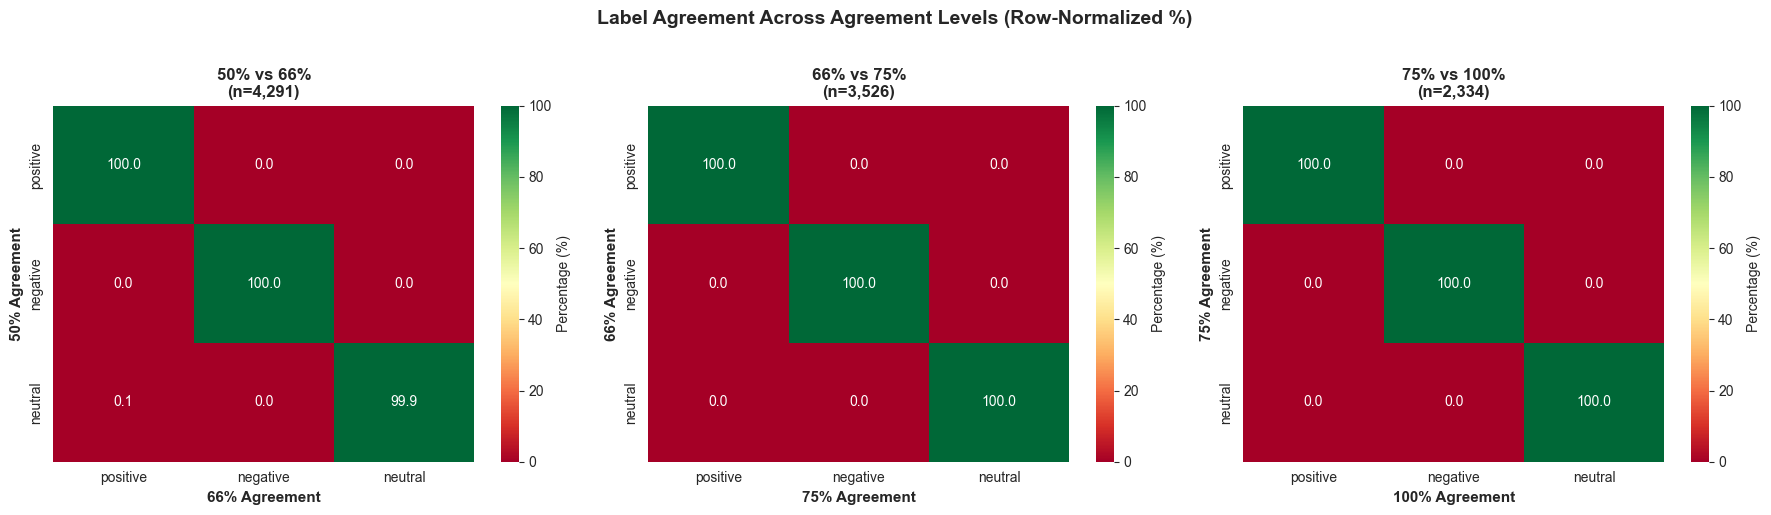

In [21]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (title, (cm, labels, total)) in enumerate(confusion_matrices.items()):
    ax = axes[idx]

    # Normalize confusion matrix for heatmap
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create heatmap
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn",
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        cbar_kws={"label": "Percentage (%)"},
        vmin=0,
        vmax=100,
    )

    level1, level2 = title.split(" vs ")
    ax.set_xlabel(f"{level2} Agreement", fontsize=11, weight="bold")
    ax.set_ylabel(f"{level1} Agreement", fontsize=11, weight="bold")
    ax.set_title(f"{title}\n(n={total:,})", fontsize=12, weight="bold")

plt.suptitle(
    "Label Agreement Across Agreement Levels (Row-Normalized %)",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("label_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

### 11.1 Most Common Disagreement Patterns


TOP 15 DISAGREEMENT PATTERNS

Format: agreement_level:label → next_level:label


  2 sentences: 50:neutral → 66:positive


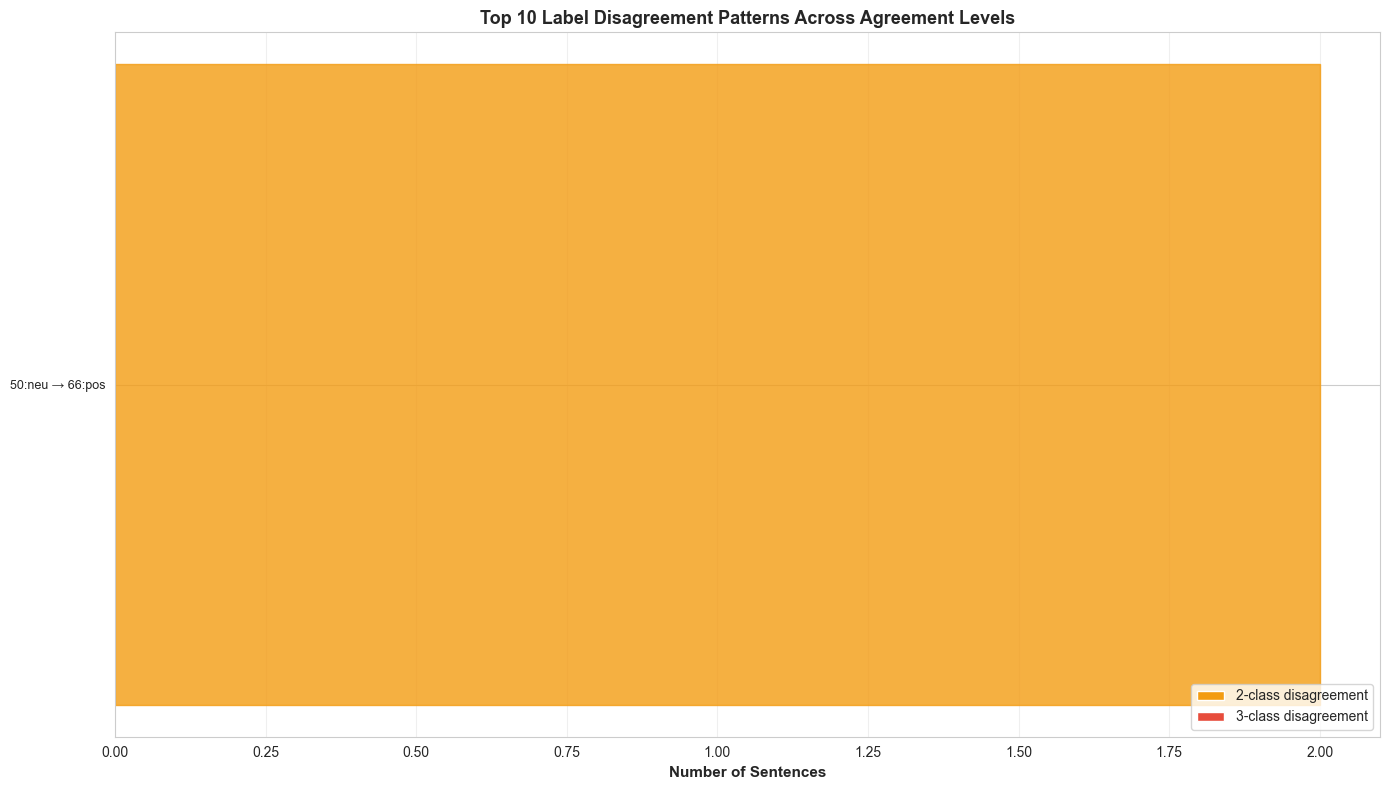

In [22]:
# Analyze common disagreement patterns
disagreement_patterns = []

for _, row in conflicts.iterrows():
    pattern = []
    for col in ["agreement_50", "agreement_66", "agreement_75", "agreement_100"]:
        if pd.notna(row[col]):
            level = col.replace("agreement_", "")
            pattern.append(f"{level}:{row[col]}")

    pattern_str = " → ".join(pattern)
    disagreement_patterns.append(
        {
            "sentence": row["sentence"],
            "pattern": pattern_str,
            "labels_involved": len(
                set(
                    [
                        row[col]
                        for col in [
                            "agreement_50",
                            "agreement_66",
                            "agreement_75",
                            "agreement_100",
                        ]
                        if pd.notna(row[col])
                    ]
                )
            ),
        }
    )

pattern_df = pd.DataFrame(disagreement_patterns)

# Count most common patterns
pattern_counts = pattern_df["pattern"].value_counts().head(15)

print("\n" + "=" * 80)
print("TOP 15 DISAGREEMENT PATTERNS")
print("=" * 80)
print("\nFormat: agreement_level:label → next_level:label")
print("\n")

for pattern, count in pattern_counts.items():
    print(f"{count:3d} sentences: {pattern}")

# Visualize top patterns
fig, ax = plt.subplots(figsize=(14, 8))

top_patterns = pattern_counts.head(10)
y_pos = np.arange(len(top_patterns))

bars = ax.barh(y_pos, top_patterns.values, alpha=0.8, edgecolor="black")

# Color bars based on whether it's a 2-class or 3-class confusion
for i, (pattern, count) in enumerate(top_patterns.items()):
    unique_labels = len(set([p.split(":")[1] for p in pattern.split(" → ")]))
    if unique_labels == 2:
        bars[i].set_color("#f39c12")  # Orange for 2-class confusion
    else:
        bars[i].set_color("#e74c3c")  # Red for 3-class confusion

ax.set_yticks(y_pos)
ax.set_yticklabels(
    [
        p.replace("agreement_", "")
        .replace(":positive", ":pos")
        .replace(":negative", ":neg")
        .replace(":neutral", ":neu")
        for p in top_patterns.index
    ],
    fontsize=9,
)
ax.invert_yaxis()
ax.set_xlabel("Number of Sentences", fontsize=11, weight="bold")
ax.set_title(
    "Top 10 Label Disagreement Patterns Across Agreement Levels",
    fontsize=13,
    weight="bold",
)
ax.grid(axis="x", alpha=0.3)

# Add legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#f39c12", label="2-class disagreement"),
    Patch(facecolor="#e74c3c", label="3-class disagreement"),
]
ax.legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.savefig("disagreement_patterns.png", dpi=300, bbox_inches="tight")
plt.show()

### 11.2 Specific Examples of Conflicting Labels

In [23]:
# Display specific examples of each type of conflict

print("\n" + "=" * 80)
print("EXAMPLES OF CONFLICTING LABELS")
print("=" * 80)

# 1. Positive ↔ Negative conflicts (most severe)
print("\n1. POSITIVE ↔ NEGATIVE CONFLICTS (Most Severe):")
print("-" * 80)

pos_neg_conflicts = conflicts[
    (
        (conflicts["agreement_50"] == "positive")
        & (conflicts["agreement_66"] == "negative")
    )
    | (
        (conflicts["agreement_50"] == "negative")
        & (conflicts["agreement_66"] == "positive")
    )
    | (
        (conflicts["agreement_66"] == "positive")
        & (conflicts["agreement_75"] == "negative")
    )
    | (
        (conflicts["agreement_66"] == "negative")
        & (conflicts["agreement_75"] == "positive")
    )
    | (
        (conflicts["agreement_75"] == "positive")
        & (conflicts["agreement_100"] == "negative")
    )
    | (
        (conflicts["agreement_75"] == "negative")
        & (conflicts["agreement_100"] == "positive")
    )
]

if len(pos_neg_conflicts) > 0:
    for idx, (_, row) in enumerate(pos_neg_conflicts.head(5).iterrows(), 1):
        print(f"\nExample {idx}:")
        print(f"Sentence: {row['sentence']}")
        labels = []
        for col in ["agreement_50", "agreement_66", "agreement_75", "agreement_100"]:
            if pd.notna(row[col]):
                level = col.replace("agreement_", "")
                labels.append(f"{level}: {row[col]}")
        print(f"Labels: {' | '.join(labels)}")
else:
    print("No direct positive↔negative conflicts found")

# 2. Positive ↔ Neutral conflicts
print("\n\n2. POSITIVE ↔ NEUTRAL CONFLICTS:")
print("-" * 80)

pos_neu_conflicts = conflicts[
    (
        (conflicts["agreement_50"] == "positive")
        & (conflicts["agreement_66"] == "neutral")
    )
    | (
        (conflicts["agreement_50"] == "neutral")
        & (conflicts["agreement_66"] == "positive")
    )
    | (
        (conflicts["agreement_66"] == "positive")
        & (conflicts["agreement_75"] == "neutral")
    )
    | (
        (conflicts["agreement_66"] == "neutral")
        & (conflicts["agreement_75"] == "positive")
    )
    | (
        (conflicts["agreement_75"] == "positive")
        & (conflicts["agreement_100"] == "neutral")
    )
    | (
        (conflicts["agreement_75"] == "neutral")
        & (conflicts["agreement_100"] == "positive")
    )
]

for idx, (_, row) in enumerate(pos_neu_conflicts.head(5).iterrows(), 1):
    print(f"\nExample {idx}:")
    print(f"Sentence: {row['sentence']}")
    labels = []
    for col in ["agreement_50", "agreement_66", "agreement_75", "agreement_100"]:
        if pd.notna(row[col]):
            level = col.replace("agreement_", "")
            labels.append(f"{level}: {row[col]}")
    print(f"Labels: {' | '.join(labels)}")

# 3. Negative ↔ Neutral conflicts
print("\n\n3. NEGATIVE ↔ NEUTRAL CONFLICTS:")
print("-" * 80)

neg_neu_conflicts = conflicts[
    (
        (conflicts["agreement_50"] == "negative")
        & (conflicts["agreement_66"] == "neutral")
    )
    | (
        (conflicts["agreement_50"] == "neutral")
        & (conflicts["agreement_66"] == "negative")
    )
    | (
        (conflicts["agreement_66"] == "negative")
        & (conflicts["agreement_75"] == "neutral")
    )
    | (
        (conflicts["agreement_66"] == "neutral")
        & (conflicts["agreement_75"] == "negative")
    )
    | (
        (conflicts["agreement_75"] == "negative")
        & (conflicts["agreement_100"] == "neutral")
    )
    | (
        (conflicts["agreement_75"] == "neutral")
        & (conflicts["agreement_100"] == "negative")
    )
]

for idx, (_, row) in enumerate(neg_neu_conflicts.head(5).iterrows(), 1):
    print(f"\nExample {idx}:")
    print(f"Sentence: {row['sentence']}")
    labels = []
    for col in ["agreement_50", "agreement_66", "agreement_75", "agreement_100"]:
        if pd.notna(row[col]):
            level = col.replace("agreement_", "")
            labels.append(f"{level}: {row[col]}")
    print(f"Labels: {' | '.join(labels)}")


EXAMPLES OF CONFLICTING LABELS

1. POSITIVE ↔ NEGATIVE CONFLICTS (Most Severe):
--------------------------------------------------------------------------------
No direct positive↔negative conflicts found


2. POSITIVE ↔ NEUTRAL CONFLICTS:
--------------------------------------------------------------------------------

Example 1:
Sentence: TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sells stake in Morning Digital Design Oy Finnish IT company TJ Group Plc said on Friday 7 April that it had signed an agreement on selling its shares of Morning Digital Design Oy to Edita Oyj .
Labels: 50: neutral | 66: positive

Example 2:
Sentence: The Group 's business is balanced by its broad portfolio of sports and presence in all major markets .
Labels: 50: neutral | 66: positive


3. NEGATIVE ↔ NEUTRAL CONFLICTS:
--------------------------------------------------------------------------------


### 11.3 Disagreement Summary by Label Transition

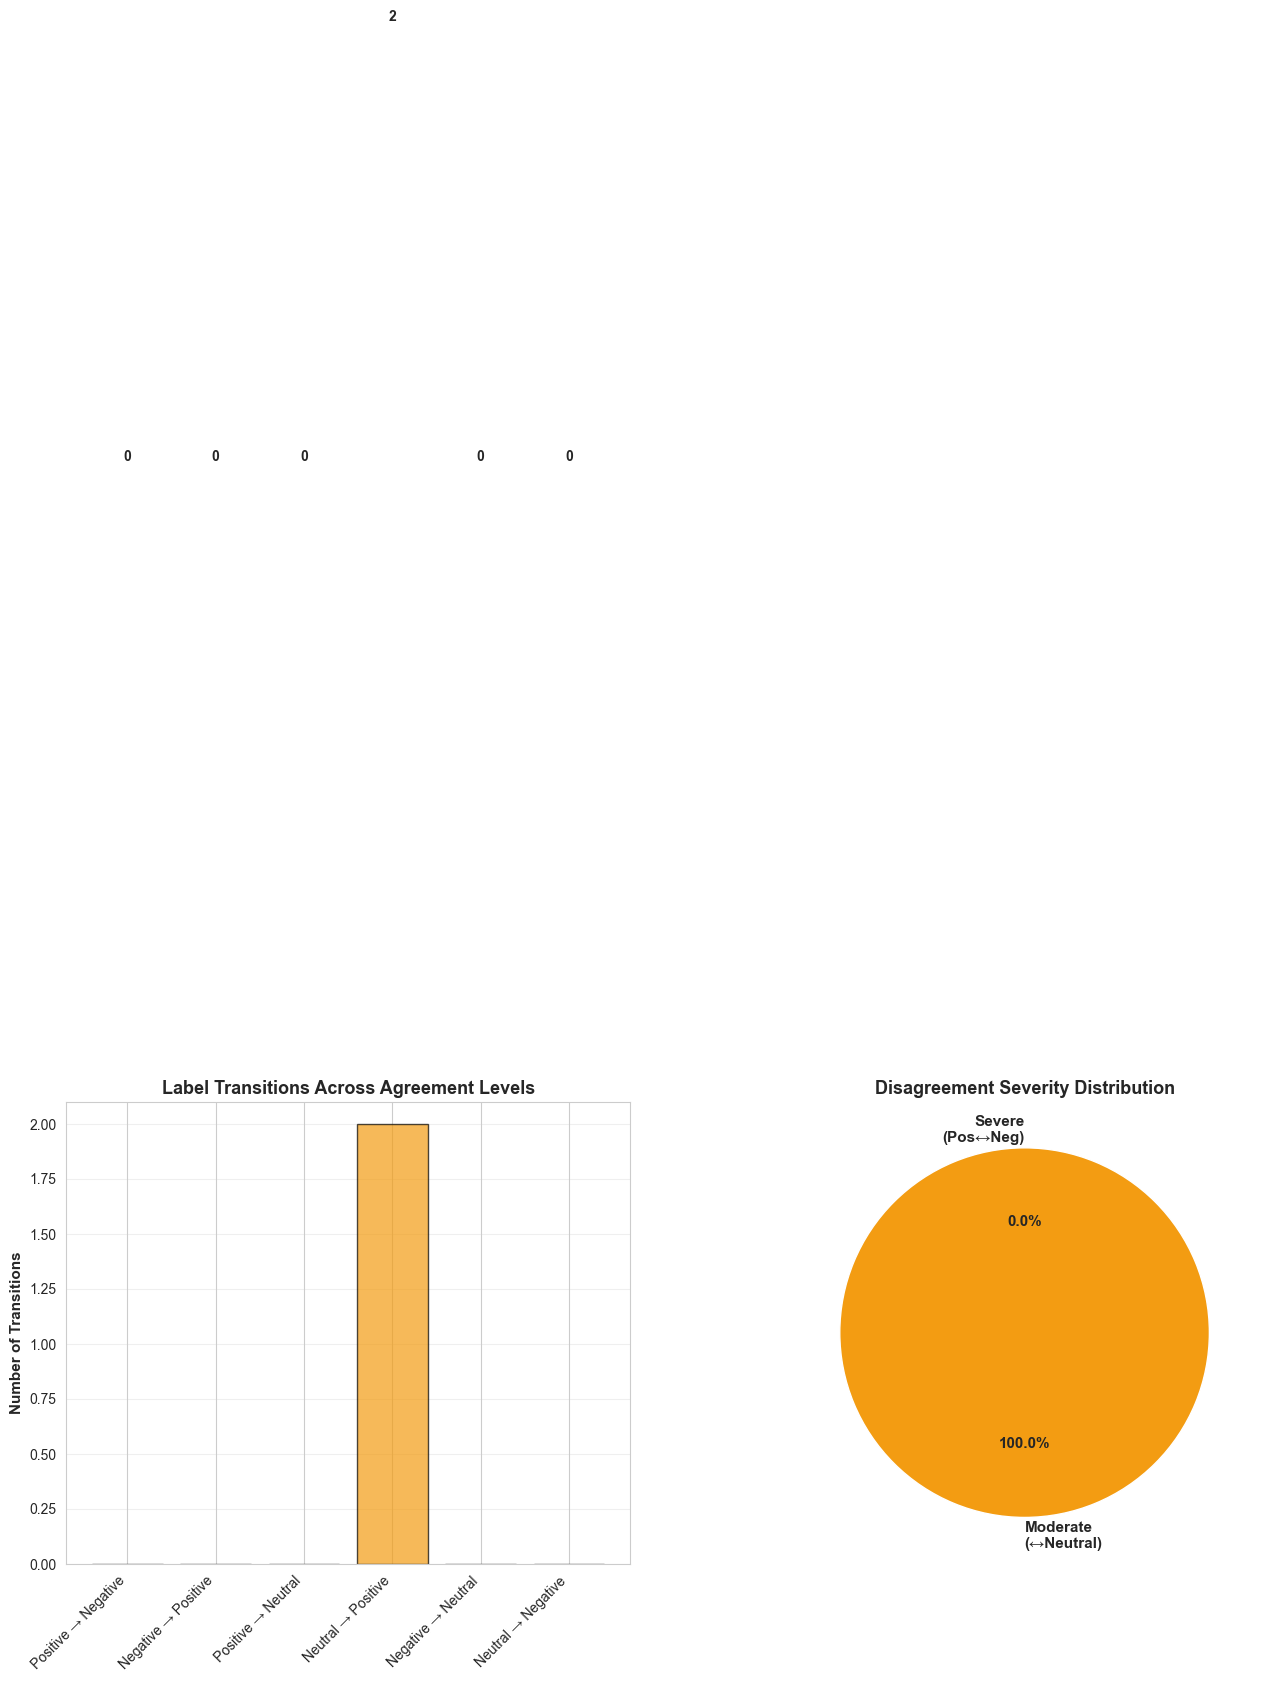


TRANSITION SUMMARY
Positive → Negative      :    0 transitions ⚠️  SEVERE
Negative → Positive      :    0 transitions ⚠️  SEVERE
Positive → Neutral       :    0 transitions ⚡ Moderate
Neutral → Positive       :    2 transitions ⚡ Moderate
Negative → Neutral       :    0 transitions ⚡ Moderate
Neutral → Negative       :    0 transitions ⚡ Moderate


In [24]:
# Analyze transition types across all agreement levels
transition_summary = {
    "Positive → Negative": 0,
    "Negative → Positive": 0,
    "Positive → Neutral": 0,
    "Neutral → Positive": 0,
    "Negative → Neutral": 0,
    "Neutral → Negative": 0,
}

# Check all consecutive transitions
for _, row in conflicts.iterrows():
    levels = ["agreement_50", "agreement_66", "agreement_75", "agreement_100"]
    labels_sequence = [(col, row[col]) for col in levels if pd.notna(row[col])]

    for i in range(len(labels_sequence) - 1):
        label1 = labels_sequence[i][1]
        label2 = labels_sequence[i + 1][1]

        if label1 != label2:
            transition_key = f"{label1.capitalize()} → {label2.capitalize()}"
            if transition_key in transition_summary:
                transition_summary[transition_key] += 1

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
transitions = list(transition_summary.keys())
counts = list(transition_summary.values())
colors_trans = ["#e74c3c", "#e74c3c", "#f39c12", "#f39c12", "#f39c12", "#f39c12"]

bars = ax1.bar(
    range(len(transitions)), counts, color=colors_trans, alpha=0.7, edgecolor="black"
)
ax1.set_xticks(range(len(transitions)))
ax1.set_xticklabels(transitions, rotation=45, ha="right")
ax1.set_ylabel("Number of Transitions", fontsize=11, weight="bold")
ax1.set_title("Label Transitions Across Agreement Levels", fontsize=13, weight="bold")
ax1.grid(axis="y", alpha=0.3)

# Add value labels
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        str(count),
        ha="center",
        va="bottom",
        fontsize=10,
        weight="bold",
    )

# Pie chart showing severity
severe = (
    transition_summary["Positive → Negative"]
    + transition_summary["Negative → Positive"]
)
moderate = (
    transition_summary["Positive → Neutral"]
    + transition_summary["Neutral → Positive"]
    + transition_summary["Negative → Neutral"]
    + transition_summary["Neutral → Negative"]
)

severity_data = [severe, moderate]
severity_labels = ["Severe\n(Pos↔Neg)", "Moderate\n(↔Neutral)"]
severity_colors = ["#e74c3c", "#f39c12"]

ax2.pie(
    severity_data,
    labels=severity_labels,
    autopct="%1.1f%%",
    colors=severity_colors,
    startangle=90,
    textprops={"fontsize": 11, "weight": "bold"},
)
ax2.set_title("Disagreement Severity Distribution", fontsize=13, weight="bold")

plt.tight_layout()
plt.savefig("label_transitions.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n" + "=" * 80)
print("TRANSITION SUMMARY")
print("=" * 80)
for transition, count in transition_summary.items():
    severity = (
        "⚠️  SEVERE"
        if "Positive → Negative" in transition or "Negative → Positive" in transition
        else "⚡ Moderate"
    )
    print(f"{transition:25s}: {count:4d} transitions {severity}")

### 11.4 Export Conflicting Sentences for Manual Review

In [25]:
# Export conflicting sentences to CSV for detailed review
export_conflicts = conflicts[
    ["sentence", "agreement_50", "agreement_66", "agreement_75", "agreement_100"]
].copy()


# Add conflict type column
def categorize_conflict(row):
    labels = set(
        [
            row[col]
            for col in ["agreement_50", "agreement_66", "agreement_75", "agreement_100"]
            if pd.notna(row[col])
        ]
    )

    if "positive" in labels and "negative" in labels:
        return "Severe (Pos↔Neg)"
    elif "positive" in labels and "neutral" in labels and "negative" not in labels:
        return "Moderate (Pos↔Neu)"
    elif "negative" in labels and "neutral" in labels and "positive" not in labels:
        return "Moderate (Neg↔Neu)"
    else:
        return "Other"


export_conflicts["conflict_type"] = export_conflicts.apply(categorize_conflict, axis=1)

# Add word count for analysis
export_conflicts["word_count"] = export_conflicts["sentence"].str.split().str.len()

# Sort by conflict type and word count
export_conflicts_sorted = export_conflicts.sort_values(["conflict_type", "word_count"])

# Export to CSV
export_conflicts_sorted.to_csv("conflicting_labels.csv", index=False)

print("\n" + "=" * 80)
print("CONFLICTING LABELS EXPORT")
print("=" * 80)
print(
    f"\n✓ Exported {len(export_conflicts_sorted):,} conflicting sentences to: conflicting_labels.csv"
)

# Summary by conflict type
print("\nBreakdown by conflict severity:")
print(export_conflicts["conflict_type"].value_counts().to_string())

# Show sample
print("\n\nSample of exported data:")
display(export_conflicts_sorted.head(10))


CONFLICTING LABELS EXPORT

✓ Exported 2 conflicting sentences to: conflicting_labels.csv

Breakdown by conflict severity:
conflict_type
Moderate (Pos↔Neu)    2


Sample of exported data:


,sentence,agreement_50,agreement_66,agreement_75,agreement_100,conflict_type,word_count
3107,The Group 's business is balanced by its broad...,neutral,positive,NaN,NaN,Moderate (Pos↔Neu),19
2944,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...,neutral,positive,NaN,NaN,Moderate (Pos↔Neu),42


### 11.5 Key Insights on Ground Truth Conflicts

In [26]:
# Final insights summary
print("\n" + "=" * 80)
print("KEY INSIGHTS: GROUND TRUTH CONFLICTS")
print("=" * 80)

total_conflicts = len(conflicts)
total_sentences = len(merged_df)
conflict_rate = (total_conflicts / total_sentences) * 100

print(f"\n📊 OVERALL STATISTICS:")
print(f"   - Total unique sentences: {total_sentences:,}")
print(f"   - Sentences with conflicts: {total_conflicts:,}")
print(f"   - Conflict rate: {conflict_rate:.2f}%")

print(f"\n🔍 CONFLICT SEVERITY:")
severe_count = export_conflicts[
    export_conflicts["conflict_type"] == "Severe (Pos↔Neg)"
].shape[0]
moderate_pos_neu = export_conflicts[
    export_conflicts["conflict_type"] == "Moderate (Pos↔Neu)"
].shape[0]
moderate_neg_neu = export_conflicts[
    export_conflicts["conflict_type"] == "Moderate (Neg↔Neu)"
].shape[0]

print(f"   - Severe (Positive ↔ Negative): {severe_count:,} sentences")
print(f"   - Moderate (Positive ↔ Neutral): {moderate_pos_neu:,} sentences")
print(f"   - Moderate (Negative ↔ Neutral): {moderate_neg_neu:,} sentences")

print(f"\n💡 IMPLICATIONS FOR MODEL EVALUATION:")
print(f"   1. Some sentences are inherently ambiguous")
print(f"   2. Using 100% agreement reduces ambiguity significantly")
print(f"   3. Model errors on ambiguous sentences may be acceptable")
print(f"   4. Focus evaluation on clear-cut cases (100% agreement)")
print(f"   5. Consider human agreement rates when setting performance targets")

print(f"\n📁 EXPORTED FILES:")
print(f"   - conflicting_labels.csv: Full list with severity classification")
print(f"   - label_confusion_matrices.png: Visual comparison of agreement levels")
print(f"   - disagreement_patterns.png: Common transition patterns")
print(f"   - label_transitions.png: Severity distribution")

print("\n" + "=" * 80)


KEY INSIGHTS: GROUND TRUTH CONFLICTS

📊 OVERALL STATISTICS:
   - Total unique sentences: 4,918
   - Sentences with conflicts: 2
   - Conflict rate: 0.04%

🔍 CONFLICT SEVERITY:
   - Severe (Positive ↔ Negative): 0 sentences
   - Moderate (Positive ↔ Neutral): 2 sentences
   - Moderate (Negative ↔ Neutral): 0 sentences

💡 IMPLICATIONS FOR MODEL EVALUATION:
   1. Some sentences are inherently ambiguous
   2. Using 100% agreement reduces ambiguity significantly
   3. Model errors on ambiguous sentences may be acceptable
   4. Focus evaluation on clear-cut cases (100% agreement)
   5. Consider human agreement rates when setting performance targets

📁 EXPORTED FILES:
   - conflicting_labels.csv: Full list with severity classification
   - label_confusion_matrices.png: Visual comparison of agreement levels
   - disagreement_patterns.png: Common transition patterns
   - label_transitions.png: Severity distribution

